In [1]:
import os
files = [f for f in os.listdir('.') if os.path.isfile(f)]
csv_files = [f for f in files if f.endswith('.csv')]

print(csv_files)

['8-7_88cm.csv', '8-7_68cm.csv', '8-7_68cm_retake.csv', '8-7_98cm.csv', '8-7_58cm.csv', '8-7_78cm.csv']


In [2]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
from scipy.stats import norm
import re

import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper")

import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
matplotlib.rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [104]:
from numpy import genfromtxt

def remove_bg(counts):
    """Removes background noise for 1minute data"""
    bg_file = "/Users/jan/Documents/References/Classes/Spring_2020/Physics_111B/gammaray_spectroscopy/8-6/background_1min.csv"
    
    bg = genfromtxt(bg_file, delimiter=',', skip_header=1, usecols=(1))
    
    if len(bg) > len(counts):
        print("here")
        arr = bg[:len(counts)].copy()
    elif len(bg) < len(counts):
        print("now here")
        arr = np.pad(bg, (0, bg.shape-counts.shape), 'constant')
    else:
        return counts - bg
    return counts - arr

def find_peaks(energies, counts):
    """
    Determines the first and second peak by first finding this highest peak. Then give the index
    where the derivative changes signs and determines next peak in index range. Ignore second peak
    if source does not contain second peak.
    
    """
    
    peak1_idx = np.argmax(counts)
    peak1 = energies[peak1_idx]
    
    holder = np.max(counts)
    
    gap_idx1 = 0
    gap_idx2 = 0
    
    for i, val in reversed(list(enumerate(counts[:peak1_idx]))):
        if (holder < val):
            gap_idx1 = i
            break
        holder = val

    holder = np.max(counts)
    
    for i, val in enumerate(counts[peak1_idx+2:]):
        if (holder < val):
            gap_idx2 = i
            break
        holder = val
        
    peak2_count = [np.max(counts[peak1_idx+gap_idx2:])]
    peak2_idxs = zip(*np.where(counts == peak2_count))
    
    peak2_idxs = np.array(list(peak2_idxs)).flatten()
    
    for loc in peak2_idxs:
        if energies[loc] > peak1:
            peak2 = energies[loc]
            peak2_idx = loc
    
    return peak1, gap_idx1, peak1_idx+gap_idx2, counts[gap_idx1]

def from_pha_data(filename):
    """
    Exports data from Pulse Height analyzer. Note only channel 0 is active.
    Returned channels have been linearly calibrated.
    """
    
    col0 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(0))
    col1 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(1))

    col1 = remove_bg(col1)/60
    
    peak1, idx1, idx2, peak_cts = find_peaks(col0, col1)
    
    # for safe measure
    col0 = col0[~np.isnan(col0)]
    col1 = col1[~np.isnan(col1)]
    
    return col0, col1, peak1, idx1, idx2, peak_cts

In [105]:
def gauss_model(x, height, mean, sigma):
    return  height * np.sqrt(2*np.pi) * sigma * norm.pdf(x, mean, sigma)

def fit_sources(channel, counts):
    """
    Fits source to gaussiam curve and returns fitted gaussian parameters.
    
    """
    #err = np.mean(np.diff(channel)) # error in bins
    
    par, cov = fitter.curve_fit(gauss_model, channel, counts, maxfev=3000)
    plt.figure()
    plt.scatter(channel, counts)
    plt.plot(channel, gauss_model(channel, *par))
    plt.show()
    
    return par, cov

377 420


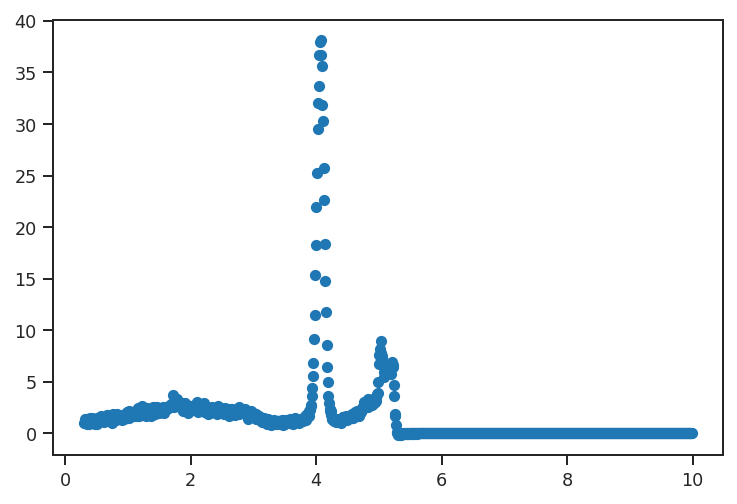

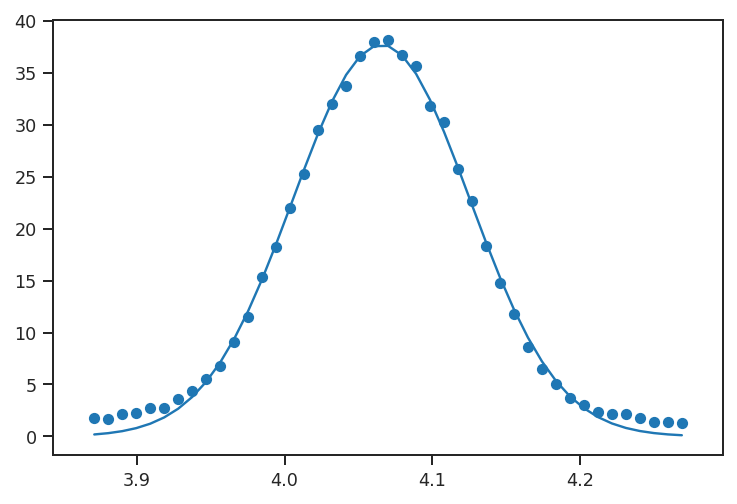

381 415


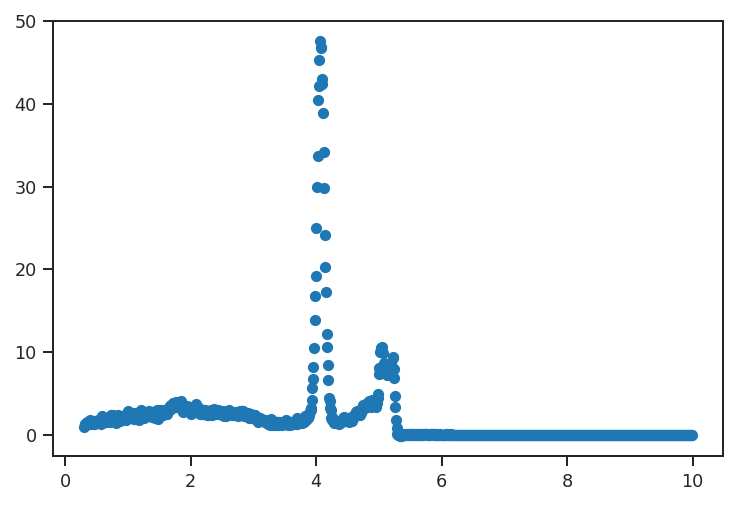

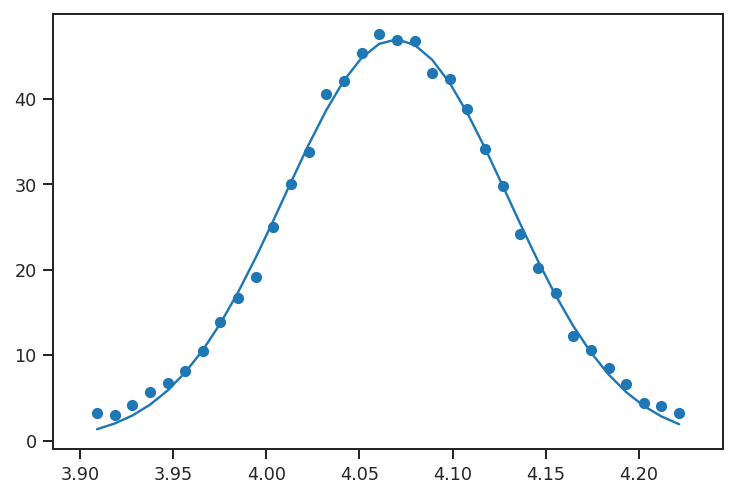

372 417


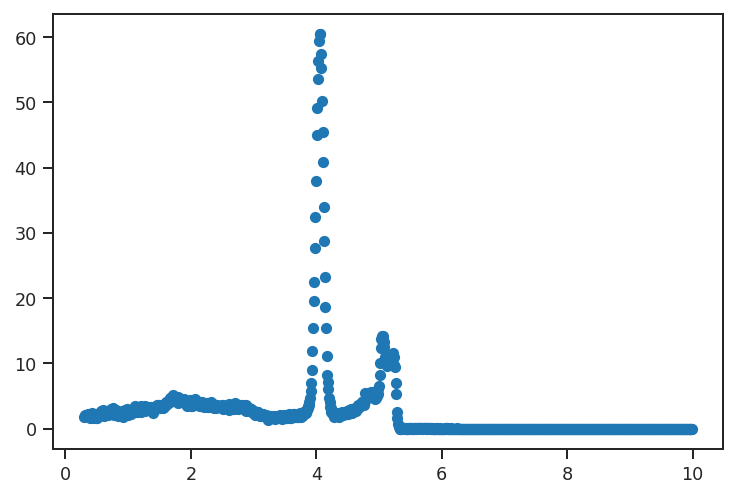

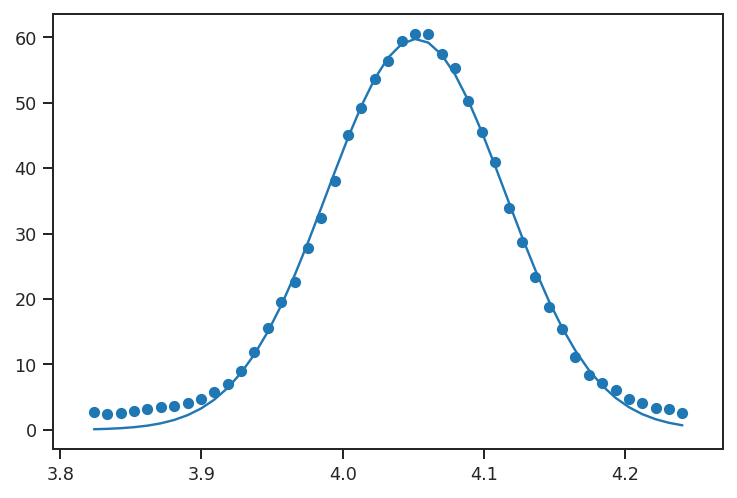

377 415


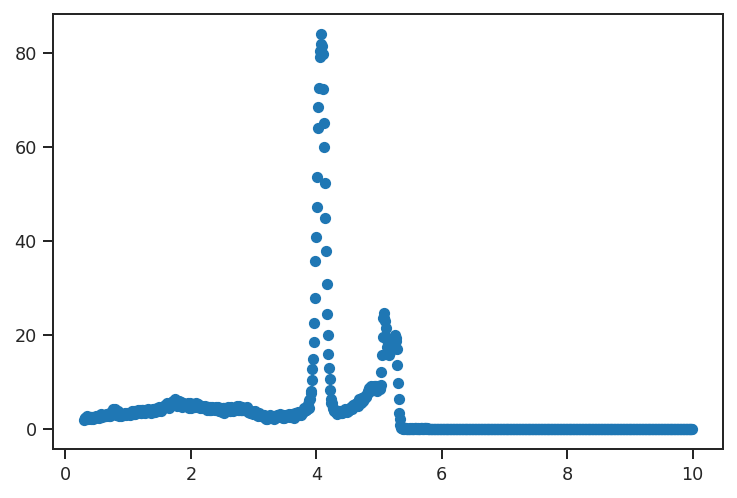

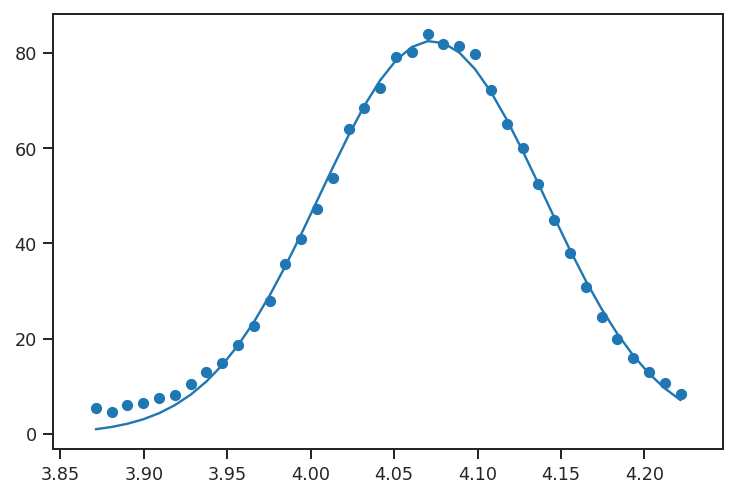

In [106]:
fn = ['8-7_58cm.csv', '8-7_68cm.csv', '8-7_78cm.csv', '8-7_98cm.csv']
inverse_data = np.array([ from_pha_data(file) for file in fn ])
fits = np.array([[],[],[]])
fits_cov = []

for i, data in enumerate(inverse_data):
    plt.scatter(data[0], data[1])
    print(data[3], data[4])
    par, cov = fit_sources(data[0][data[3]:data[4]], data[1][data[3]:data[4]])
    fits = np.insert(fits, i, par, axis=1)
    fits_cov.append(cov)

In [107]:
def linear_model(x, a):
    return a*x

ys = np.array([0.84]*4)
print(ys)
par_mn, cov_mn = fitter.curve_fit(linear_model, fits[1], ys, maxfev=4000)
print(par_mn)

[0.84 0.84 0.84 0.84]
[0.20664371]


In [108]:
distances = np.array([158-58, 158-68, 158-78, 158-98])*10**(-2) # Distances in meters

(0, 88.24333333333333)

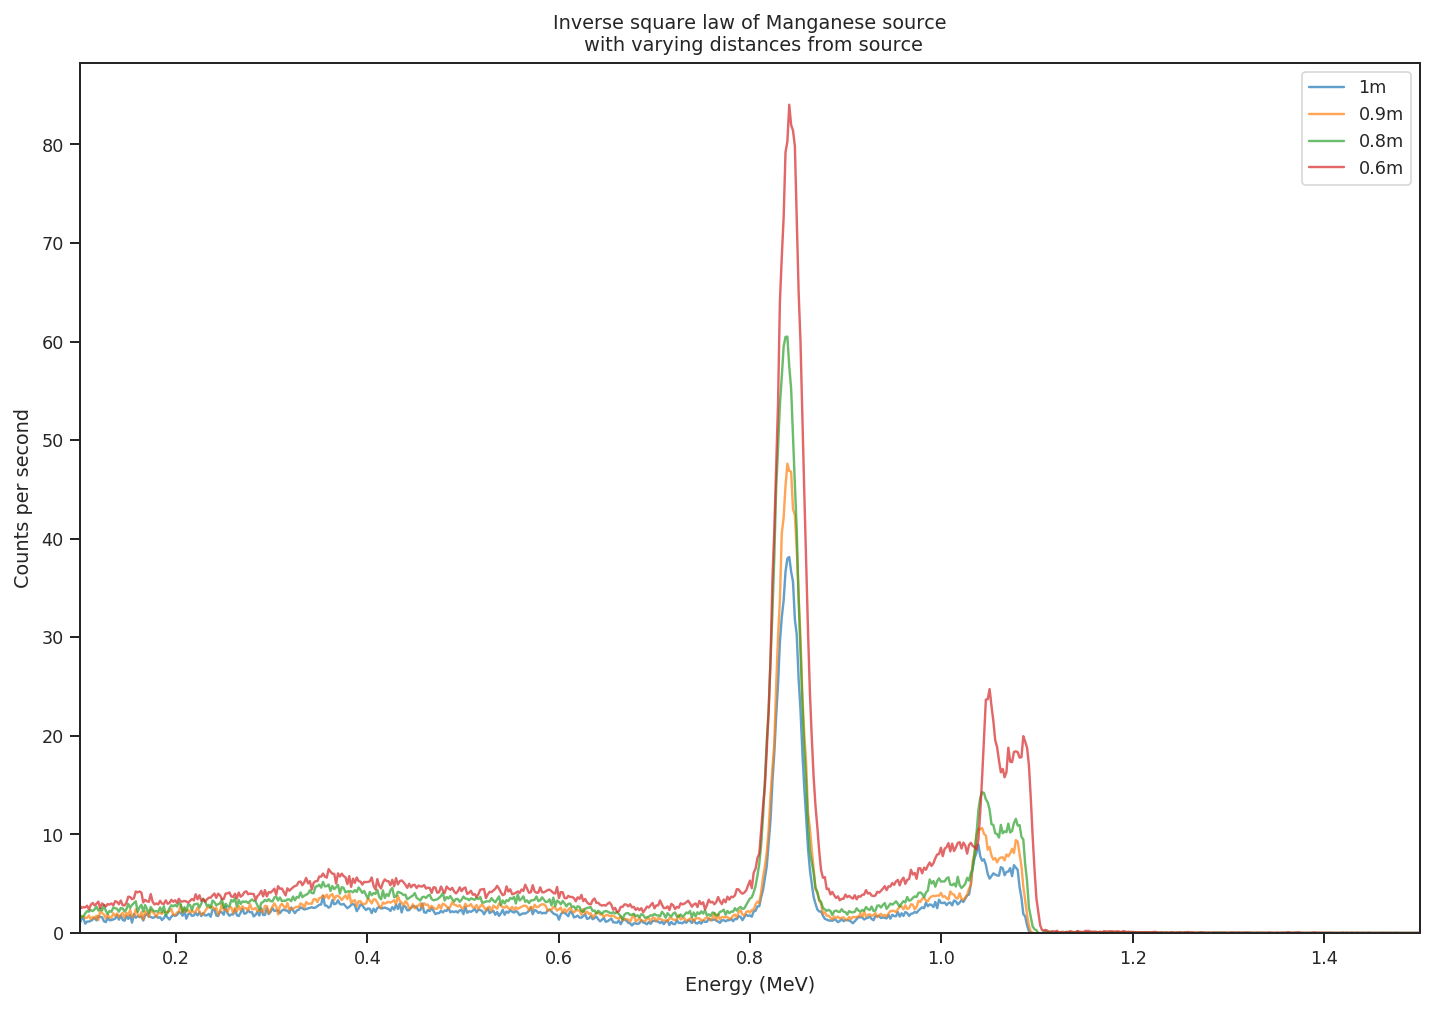

In [111]:
plt.figure(figsize=(12,8))
for i, data in enumerate(inverse_data):
    plt.plot(linear_model(data[0], *par_mn), data[1], ls='-', alpha=0.7)

plt.title("Inverse square law of Manganese source\n with varying distances from source")
plt.legend(["1m", "0.9m", "0.8m", "0.6m"])
plt.ylabel("Counts per second")
plt.xlabel("Energy (MeV)")
plt.xlim(0.1, 1.5)
plt.ylim(0)

In [164]:
def inv_square_const(intensity, distance):
    return intensity*distance**2

def inv_error(intensity, distance, intensity_err):
    """Find errors in constants where distance has half a centimeter error"""
    return np.sqrt((intensity_err/intensity)**2 + 2*(0.005/distance)**2)*(intensity*distance**2)

constants = []
for i, data in enumerate(inverse_data):
    constants.append(inv_square_const(fits[0][i], distances[i]))

errors = []
for i, data in enumerate(inverse_data):
    errors.append(inv_error(fits[0][i], distances[i], np.sqrt(np.diag(fits_cov[i]))[0]))

constant = np.array(constants)
errors = np.array(errors)

for i in range(len(constants)):
    print(fits[0][i], np.sqrt(np.diag(fits_cov[i]))[0], distances[i], constants[i], errors[i])

37.68980420716232 0.3108841186876231 1.0 37.68980420716232 0.6170520265642324
46.98726481946169 0.37800175939116576 0.9 38.059684503763975 0.6718713865206364
59.74011575764415 0.49704851371948544 0.8 38.233674084892264 0.7470016482515361
82.5712914948255 0.6584673079389579 0.6 29.72566493813718 0.7396547658535076


[98.07738052 71.35214275 54.22950494 42.60489516 34.35363474 28.28637758]
[32.99323081] [2.35284687] [38.07074044] [0.14545403]


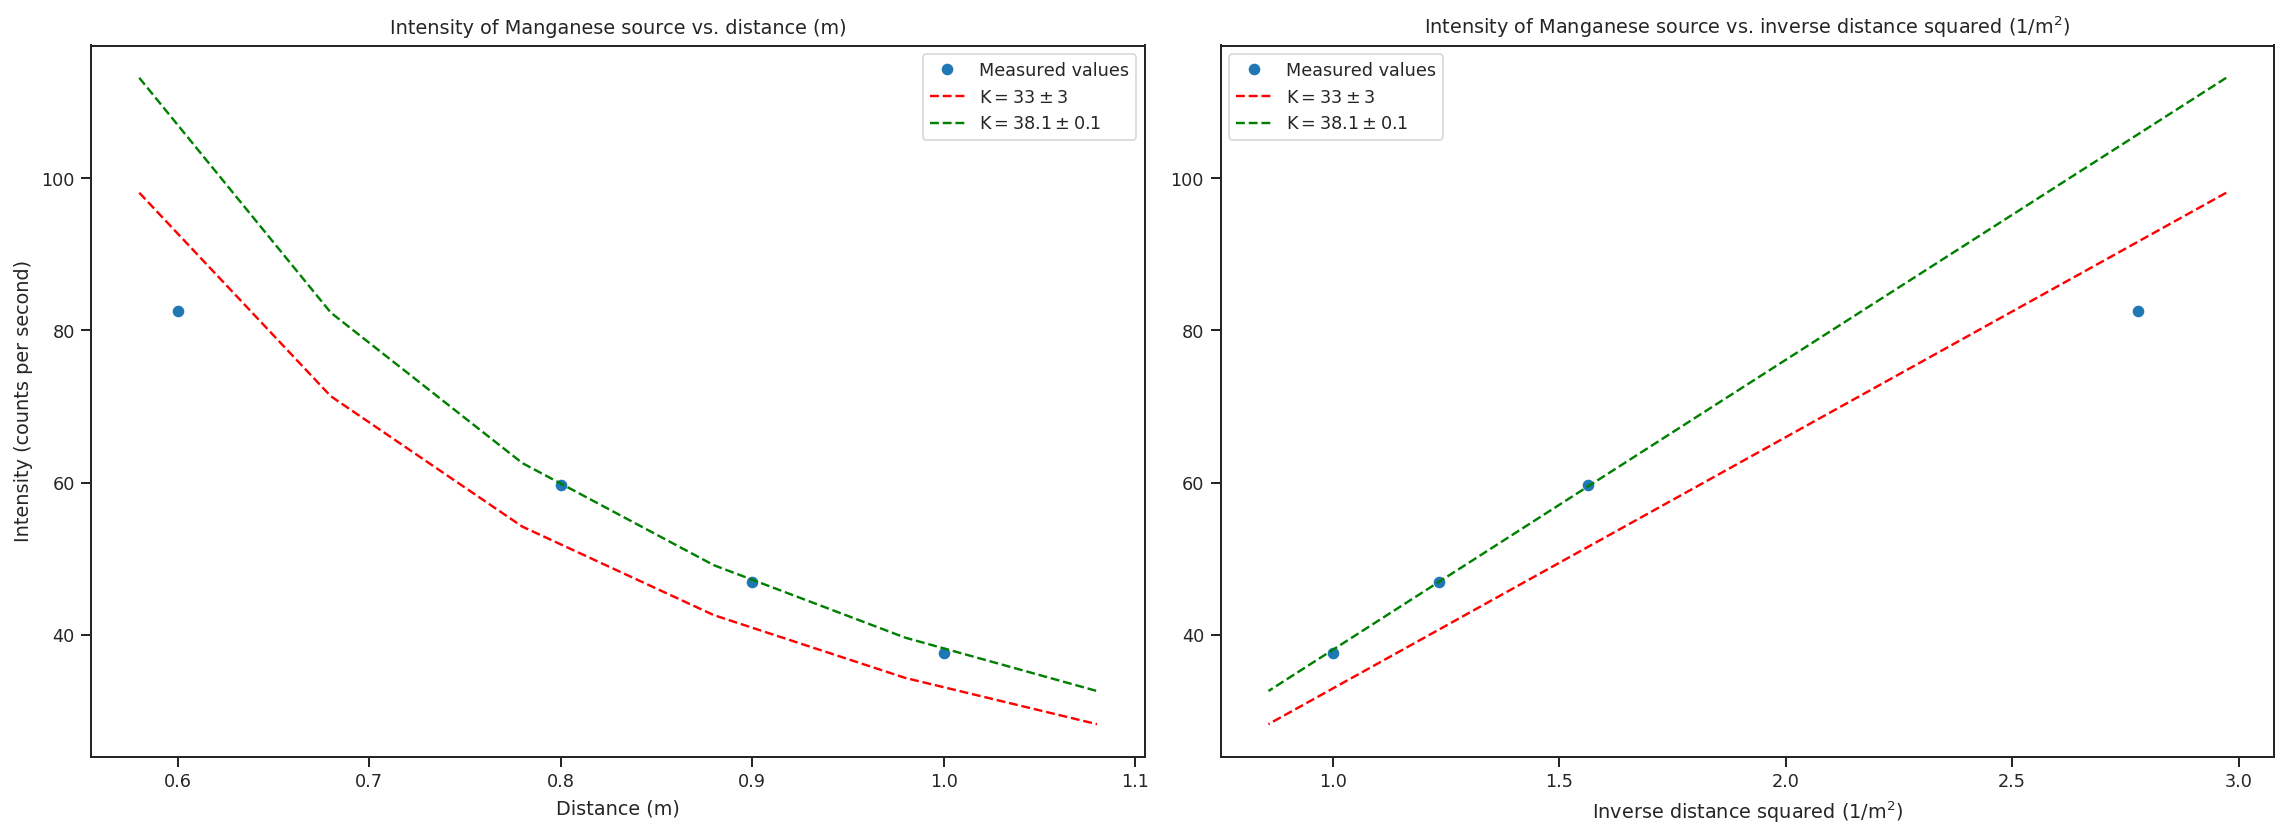

In [163]:
def inv_model(x, k):
    return k/x**2
xs = np.arange(.58, 1.1, 0.1)

par1, cov1 = fitter.curve_fit(inv_model, distances, fits[0], maxfev=4000)
par2, cov2 = fitter.curve_fit(inv_model, distances[:-1], fits[0][:-1], maxfev=4000)

plt.subplots(1, 2, sharey=True, figsize=(16,6))

plt.subplot(121)
plt.title("Intensity of Manganese source vs. distance (m)")
plt.plot(distances, fits[0], 'o', label="Measured values")
plt.plot(xs, inv_model(xs, *par1), 'r--', label=r"$ K = 33 \pm 3$")
plt.plot(xs, inv_model(xs, *par2), 'g--', label=r"$K = 38.1 \pm 0.1$")
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Intensity (counts per second)")
plt.tight_layout()

plt.subplot(122)
plt.title(r"Intensity of Manganese source vs. inverse distance squared $(1/m^2)$")
plt.plot(1/distances**2, fits[0], 'o', label="Measured values")
plt.plot(1/xs**2, inv_model(xs, *par1), 'r--', label=r"$ K = 33 \pm 3$")
plt.plot(1/xs**2, inv_model(xs, *par2), 'g--', label=r"$K = 38.1 \pm 0.1$")
plt.legend()
plt.xlabel(r"Inverse distance squared $(1/m^2)$")
plt.tight_layout()

print(inv_model(xs, *par1))
print(par1, np.sqrt(np.diag(cov1)),  par2, np.sqrt(np.diag(cov2)))